In [1]:
import numpy as np
import scipy.io.wavfile
import os
import librosa as lb
import librosa.display
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense , Dropout , Activation , Flatten , Conv1D, Conv2D , MaxPooling1D, MaxPooling2D , ZeroPadding2D ,MaxPool1D
from matplotlib import pyplot as plt
from IPython.display import Audio
from keras.layers.normalization import BatchNormalization
from keras.regularizers import l2
# from google.colab import drive 
# drive.mount('/content/drive')


In [ ]:
# !unrar x '/content/drive/MyDrive/crema/Crema.rar' -d '/content/'

MAX_FILES = 7442
FILE_LIMIT = 7442

# The folder containing the Crema dataset
dataFolder = '/data/Crema'

# The names of all files in the Crema dataset
soundFiles = os.listdir(path=dataFolder)
soundFiles.sort()
soundFiles[0]
# Sanity check: checking if all sound files are downloaded correctly
# Spoiler: They were.
len(soundFiles)

Streaming output truncated to the last 5000 lines.
Extracting  /content/Crema/1031_DFA_FEA_XX.wav                            33%  OK 
Extracting  /content/Crema/1031_DFA_HAP_XX.wav                            33%  OK 
Extracting  /content/Crema/1031_DFA_NEU_XX.wav                            34%  OK 
Extracting  /content/Crema/1031_DFA_SAD_XX.wav                            34%  OK 
Extracting  /content/Crema/1031_IEO_ANG_HI.wav                            34%  OK 
Extracting  /content/Crema/1031_IEO_ANG_LO.wav                            34%  OK 
Extracting  /content/Crema/1031_IEO_ANG_MD.wav                            34%  OK 
Extracting  /content/Crema/1031_IEO_DIS_HI.wav                            34%  OK 
Extracting  /content/Crema/1031_IEO_DIS_LO.wav                            34%  OK 
Extracting  /content/Crema/1031_IEO_DIS_MD.wav                            34%  OK 
Extracting  /content/Crema/10

7442

In [ ]:
#bisho: we will read every sample into fs(sampling freq) and data.
#and create labels array by checking every name for words SAD,ANG,DIS,FEA,HAP,and NEU and save them as corresponding labels 0,1,2,3,4,and 5 respectivly
# 6 is an error/unknown emotion
labels=np.zeros(FILE_LIMIT)

classes={0:"SAD" , 1:"ANGRY" , 2:"DISGUST" , 3:"FEAR" , 4:"HAPPY" , 5:"NEUTRAL"}
fs={}
data=[]
i=0
for sample in soundFiles:
    
    # fs[i], data[i] = scipy.io.wavfile.read(dataFolder+"/"+sample)
    samp, sr = lb.load(dataFolder+"/"+sample, offset=0.2, duration=3 , sr=None)
    data.append(samp)
    # print(sample)
    token = sample.partition(".wav")[0].split("_")
    if token[2] == 'SAD':
        labels[i]=0;
    elif token[2] == 'ANG':
        labels[i]=1;
    elif token[2] == 'DIS':
        labels[i]=2;
    elif token[2] == 'FEA':
        labels[i]=3;
    elif token[2] == 'HAP':
        labels[i]=4;
    elif token[2] == 'NEU':
        labels[i]=5;
    else:
        labels[i]=6;

    i=i+1

    # To reduce loading time while developing
    if i >= FILE_LIMIT:
        break;
    # print(i, ' ', end='')



mx=80080
mn=20287
#padding
k=int(data[0].shape[0])
for i in range(FILE_LIMIT):
    data[i]=np.pad(data[i], pad_width=(0,48000-data[i].shape[0]))
    k=int(data[i].shape[0])
    #print(k)
#length limit
#for i in range(FILE_LIMIT):
    #data[i]=data[i][0:(mn)] #reducing sample sizes to be equal
    #k=data[i].shape[0]
    #data[i]=librosa.effects.time_stretch(data[i], ( k/ (2.5*sr))  )
    #print(data[i].shape)

#bisho: later we might want to use noise , stretching , pitching , shifting variations to improve accuracy






In [ ]:
import math
def get_white_noise(signal,SNR) :
    #RMS value of signal
    RMS_s=math.sqrt(np.mean(signal**2))
    #RMS values of noise
    RMS_n=math.sqrt(RMS_s**2/(pow(10,SNR/10)))
    #Additive white gausian noise. Thereore mean=0
    #Because sample length is large (typically > 40000)
    #we can use the population formula for standard daviation.
    #because mean=0 STD=RMS
    STD_n=RMS_n
    noise=np.random.normal(0, STD_n, signal.shape[0])
    return noise

In [ ]:
from sklearn.model_selection import train_test_split
#spliting dataset

x_train, x_test, y_train, y_test = train_test_split(data, labels, test_size=0.3 )
print(x_train[0].shape)
x_train=np.array(x_train)
x_test=np.array(x_test)
y_train=np.array(y_train)
y_test=np.array(y_test)
sh=x_train.shape[1]
print(x_train[0].shape)
print(sh)
#augmenting training dataset
moded_xtrain = []
moded_ytrain=[]
for i in range(5209):

  
  withnoise =  get_white_noise(x_train[i] ,7)
  withpitch=librosa.effects.pitch_shift(x_train[i], sr , 0.7)

  moded_xtrain.append(x_train[i])
  moded_xtrain.append(withnoise)
  moded_xtrain.append(withpitch)

  moded_ytrain.append(y_train[i])
  moded_ytrain.append(y_train[i])
  moded_ytrain.append(y_train[i])

(48000,)
(48000,)
48000


In [ ]:
port= len(moded_xtrain)/10; # take 5 percent wiTH zero frequency and distrbute labels equally on them 
port= port-port%6;
port=int(port)
for i in range(port) :
  moded_xtrain.append(np.zeros(40000))
  moded_ytrain.append(i%6)

In [ ]:
#+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
#+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
# converting all time series voice into mel-spectrogram 
# it takes quite some time. We could shorten the list of files if needed

moded_xtrain=np.array(moded_xtrain)
moded_ytrain=np.array(moded_ytrain)
print(moded_ytrain.shape)
print(y_test.shape)

mel_train = []

for i in range(5209*3):
    S = lb.feature.melspectrogram(moded_xtrain[i], sr,n_fft=1024,
                                              win_length = 512,
                                              window='hamming',
                                              hop_length = 256,
                                              n_mels=128,
                                              fmax=16000/2)
    mel_spec_db = librosa.power_to_db(S, ref=np.max)
    mel_train.append(mel_spec_db)

del moded_xtrain #for ram usage
mel_test = []

for i in range(2233):
    S = lb.feature.melspectrogram(x_test[i], sr,n_fft=1024,
                                              win_length = 512,
                                              window='hamming',
                                              hop_length = 256,
                                              n_mels=128,
                                              fmax=16000/2)
    mel_spec_db = librosa.power_to_db(S, ref=np.max)
    mel_test.append(mel_spec_db)





(15627,)
(2233,)


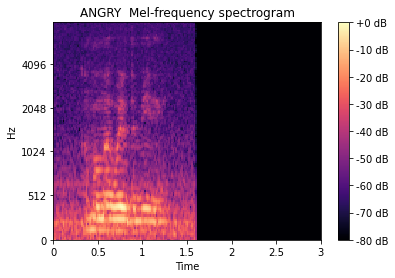

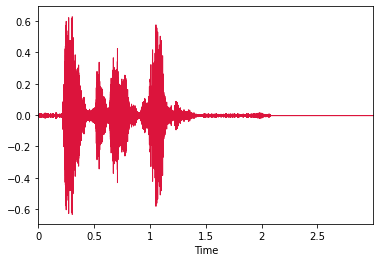

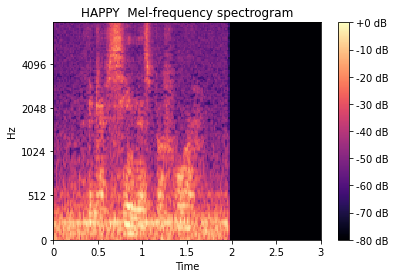

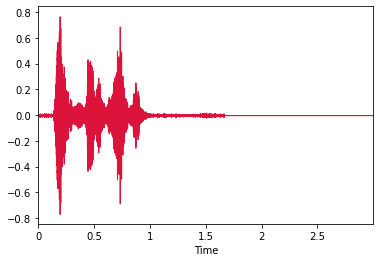

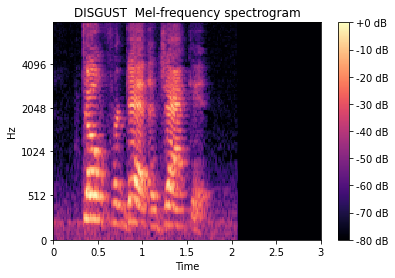

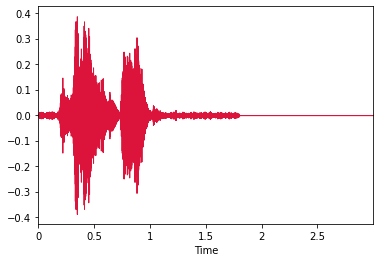

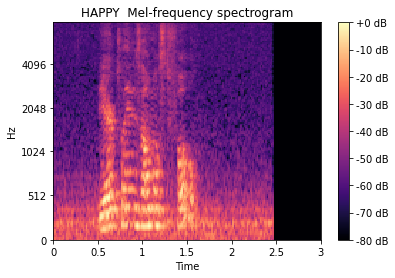

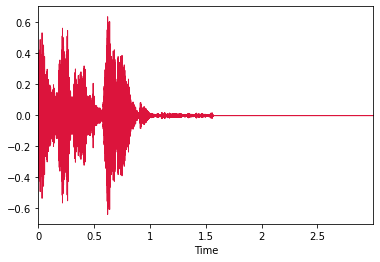

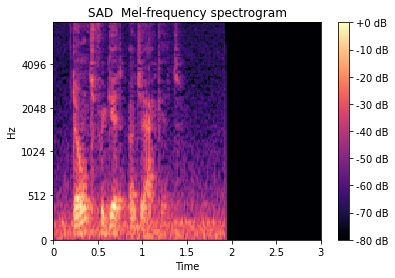

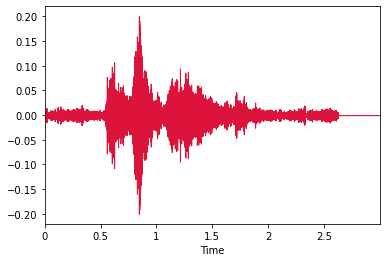

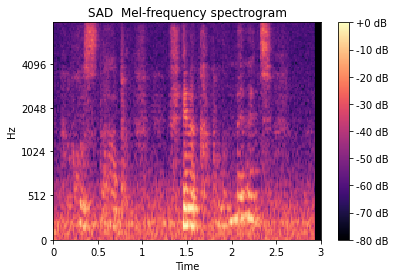

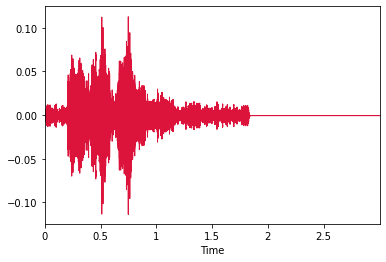

In [ ]:


#MEL SPECTOGRAMS
cls_samples=[]
cls_samples.append(0)
clses=[0,1,2,3,4,5]
clses.remove(moded_ytrain[0])
for i in range(5209-1):
    if(moded_ytrain[i+1]!=moded_ytrain[i] and (moded_ytrain[i+1] in clses)):
        cls_samples.append(i+1)
        clses.remove(moded_ytrain[i+1])
        #print(labels[i+1])
        if(len(cls_samples)==6):
            break;

#bisho : ploting melspectogram and time domain for the first audio in each class (emotion)
for i in cls_samples:
    
    fig, ax = plt.subplots()
    #print(melspectrogram_array[i].shape)
    
    img = lb.display.specshow(mel_train[i], x_axis='time',y_axis='mel', sr=sr*2,fmax=8000, ax=ax)

    fig.colorbar(img, ax=ax, format='%+2.0f dB')
    ax.set(title=str(classes[labels[i]]) + '  Mel-frequency spectrogram')
    plt.show()
    librosa.display.waveplot(data[i],sr=sr, color='#dc143c')
    plt.show()



In [ ]:
# Properly reshaping arrays, 1 is to segnify 1d values for "pixels"
from tensorflow.keras.utils import to_categorical
mel_train = tf.expand_dims(mel_train, axis=-1)
mel_test = tf.expand_dims(mel_test, axis=-1)

print(mel_test.shape)
#print(moded_xtrain.shape)
sh=mel_train[0].shape
print(sh)


moded_ytrain=to_categorical(moded_ytrain)
y_test=to_categorical(y_test)

(2233, 128, 188, 1)
(128, 188, 1)


In [ ]:
tf.keras.backend.clear_session()

#bisho: pdf example 
model = Sequential()
model.add(Conv2D(512,(5,5), padding='valid' , activation='relu' )) #sh is shape variable
model.add(MaxPooling2D(pool_size=(5,5), strides=2, padding="valid"))
model.add(Conv2D(512,(5,5) , padding='valid' ,activation='relu' ))
model.add(MaxPooling2D(pool_size=(5,5),strides=2, padding='valid'))
model.add(Conv2D(128,(5,5) , activation='relu', padding='valid'))
model.add(MaxPooling2D(pool_size=(5,5),strides=2, padding='valid'))
model.add(Flatten())
model.add(Dense(256,activation='relu'))
model.add(Dense(6,activation='softmax')) #6 classes
model.compile(loss='categorical_crossentropy',optimizer="adam",metrics=['accuracy'])

#bisho: clone of alexnet
model2 = Sequential()

model2.add(Conv2D(96, (11, 11), input_shape=sh, padding='same', kernel_regularizer=l2(0.)))
model2.add(BatchNormalization())
model2.add(Activation('relu'))
model2.add(MaxPooling2D(pool_size=(2, 2)))
	
model2.add(Conv2D(256, (5, 5), padding='same'))
model2.add(BatchNormalization())
model2.add(Activation('relu'))
model2.add(MaxPooling2D(pool_size=(3, 3)))
	
model2.add(ZeroPadding2D((1, 1)))
model2.add(Conv2D(384, (3, 3), padding='same'))
model2.add(BatchNormalization())
model2.add(Activation('relu'))
model2.add(MaxPooling2D(pool_size=(3, 3)))
	
model2.add(ZeroPadding2D((1, 1)))
model2.add(Conv2D(384, (3, 3), padding='same'))
model2.add(BatchNormalization())
model2.add(Activation('relu'))

	
model2.add(ZeroPadding2D((1, 1)))
model2.add(Conv2D(256, (3, 3), padding='same'))
model2.add(BatchNormalization())
model2.add(Activation('relu'))
model2.add(MaxPooling2D(pool_size=(3, 3)))
	
model2.add(Flatten())
model2.add(Dense(4096))
model2.add(BatchNormalization())
model2.add(Activation('relu'))
	
model2.add(Dense(4096))
model2.add(BatchNormalization())
model2.add(Activation('relu'))
	
model2.add(Dense(6))
model2.add(BatchNormalization())
model2.add(Activation('softmax'))

model2.compile(loss='categorical_crossentropy',
             optimizer="adam",
             metrics=['accuracy'])
model2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 128, 188, 96)      11712     
_________________________________________________________________
module_wrapper (ModuleWrappe (None, 128, 188, 96)      384       
_________________________________________________________________
activation (Activation)      (None, 128, 188, 96)      0         
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 64, 94, 96)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 64, 94, 256)       614656    
_________________________________________________________________
module_wrapper_1 (ModuleWrap (None, 64, 94, 256)       1024      
_________________________________________________________________
activation_1 (Activation)    (None, 64, 94, 256)      

In [ ]:
from tensorflow.python.keras.callbacks import EarlyStopping, ReduceLROnPlateau
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy',
                                            patience=3,
                                            verbose=1,
                                            factor=0.5,
                                            min_lr=0.00001)


record=model2.fit(mel_train, moded_ytrain , epochs=15, validation_data=(mel_test, y_test), callbacks=[learning_rate_reduction])

Epoch 1/15
489/489 [==============================] - 113s 160ms/step - loss: 1.5500 - accuracy: 0.3512 - val_loss: 1.5026 - val_accuracy: 0.4084
Epoch 2/15
489/489 [==============================] - 78s 160ms/step - loss: 1.4496 - accuracy: 0.3943 - val_loss: 1.3292 - val_accuracy: 0.4993
Epoch 3/15
489/489 [==============================] - 80s 164ms/step - loss: 1.3685 - accuracy: 0.4284 - val_loss: 1.5098 - val_accuracy: 0.3887
Epoch 4/15
489/489 [==============================] - 80s 165ms/step - loss: 1.3005 - accuracy: 0.4594 - val_loss: 1.6984 - val_accuracy: 0.3659
Epoch 5/15
489/489 [==============================] - 81s 165ms/step - loss: 1.2233 - accuracy: 0.4931 - val_loss: 1.4445 - val_accuracy: 0.4313

Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Epoch 6/15
489/489 [==============================] - 81s 165ms/step - loss: 1.0768 - accuracy: 0.5565 - val_loss: 1.4438 - val_accuracy: 0.5128
Epoch 7/15
489/489 [============================

In [ ]:
record=model2.fit(mel_train, moded_ytrain , epochs=15, validation_data=(mel_test, y_test), callbacks=[learning_rate_reduction])

Epoch 1/15
489/489 [==============================] - 78s 159ms/step - loss: 0.5981 - accuracy: 0.7685 - val_loss: 1.2410 - val_accuracy: 0.5916
Epoch 2/15
489/489 [==============================] - 80s 163ms/step - loss: 0.5587 - accuracy: 0.7930 - val_loss: 1.2594 - val_accuracy: 0.5943
Epoch 3/15
489/489 [==============================] - 81s 165ms/step - loss: 0.5047 - accuracy: 0.8195 - val_loss: 1.2006 - val_accuracy: 0.6086
Epoch 4/15
489/489 [==============================] - 81s 165ms/step - loss: 0.4243 - accuracy: 0.8548 - val_loss: 1.2553 - val_accuracy: 0.5934
Epoch 5/15
489/489 [==============================] - 81s 165ms/step - loss: 0.3198 - accuracy: 0.9025 - val_loss: 1.3205 - val_accuracy: 0.5813
Epoch 6/15
489/489 [==============================] - 81s 165ms/step - loss: 0.2145 - accuracy: 0.9501 - val_loss: 1.2407 - val_accuracy: 0.6023

Epoch 00006: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.
Epoch 7/15
489/489 [==============================

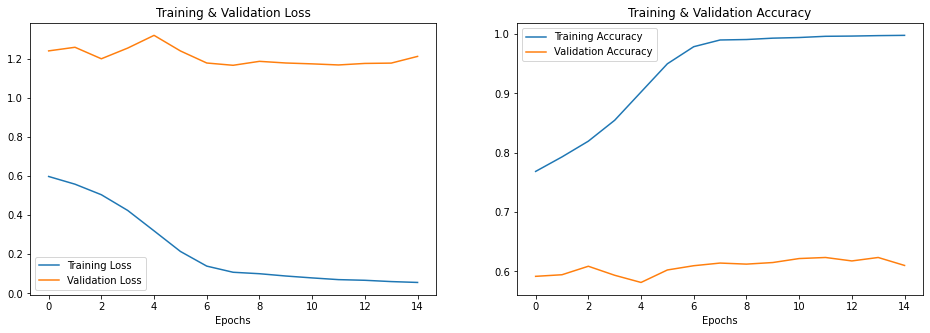

              precision    recall  f1-score   support

           0       0.50      0.61      0.55       360
           1       0.72      0.75      0.74       383
           2       0.63      0.44      0.52       378
           3       0.52      0.56      0.54       384
           4       0.61      0.62      0.62       374
           5       0.69      0.68      0.69       354

    accuracy                           0.61      2233
   macro avg       0.62      0.61      0.61      2233
weighted avg       0.62      0.61      0.61      2233



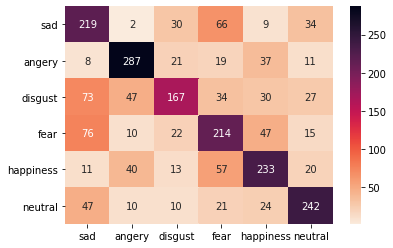

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import seaborn as sns

#graphs , confusion matrix ,and f meausre
train_ac = record.history['accuracy']
train_loss = record.history['loss']
test_ac = record.history['val_accuracy']
test_loss = record.history['val_loss']

fig , ax = plt.subplots(1,2)
fig.set_size_inches(16,5)
ax[0].plot(train_loss, label = 'Training Loss')
ax[0].plot(test_loss , label = 'Validation Loss')
ax[0].set_title('Training & Validation Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(train_ac, label = 'Training Accuracy')
ax[1].plot(test_ac , label = 'Validation Accuracy')
ax[1].set_title('Training & Validation Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()


#SAD,ANG,DIS,FEA,HAP,and NEU and save them as corresponding labels 0,1,2,3,4,5,and 6 respectivly

y_pred = model2.predict(mel_test)
y_pred_bool = np.argmax(y_pred, axis=1)
re= np.argmax(y_test, axis=1)
print(classification_report(re, y_pred_bool))

matrix = confusion_matrix(re, y_pred.argmax(axis=1))
ax = sns.heatmap(matrix, annot=True, fmt="d", cmap = 'rocket_r', xticklabels = ['sad','angery','disgust','fear', 'happiness', 'neutral'], yticklabels = ['sad','angery','disgust','fear', 'happiness', 'neutral'])
